# Импорт библиотек

In [ ]:
import optuna
import numpy as np
import pandas as pd
import seaborn as sns
from copy import deepcopy

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

import sklearn.svm
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import RandomOverSampler

import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler


# Функции 

In [ ]:
def statistic(y_pred_test, y_test, y_pred_train, y_train):
    score_table = pd.DataFrame(columns=('train', 'test'))

    b_train = balanced_accuracy_score(y_train, y_pred_train)
    b_test = balanced_accuracy_score(y_test, y_pred_test)
    score_table.loc['balanced_accuracy_score', :] = (b_train, b_test)

    a_train = accuracy_score(y_train, y_pred_train)
    a_test = accuracy_score(y_test, y_pred_test)
    score_table.loc['accuracy_score', :] = (a_train, a_test)

    f1_train = f1_score(y_train, y_pred_train, average='weighted')
    f1_test = f1_score(y_test, y_pred_test, average='weighted')
    score_table.loc['f1 weighted', :] = (f1_train, f1_test)

    f1_train = f1_score(y_train, y_pred_train, average='micro')
    f1_test = f1_score(y_test, y_pred_test, average='micro')
    score_table.loc['f1 micro', :] = (f1_train, f1_test)

    f1_train = f1_score(y_train, y_pred_train, average='macro')
    f1_test = f1_score(y_test, y_pred_test, average='macro')
    score_table.loc['f1 macro', :] = (f1_train, f1_test)

    return score_table

In [ ]:
def cm_plot(y_test, y_pred, y_type):

    cm = confusion_matrix(y_test, y_pred)
    # Normalise
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(5,5))
    sns.heatmap(cmn, cmap='Blues', annot=True, fmt='.2f')
    sns.set(font_scale=1.3)
    plt.title(f'Confusion Matrix of {y_type}')

    return plt.show()

In [ ]:
def decoder_npy(path): #достает созданный выше словарь из файла
    data = np.load(path, allow_pickle=True)
    d = dict(enumerate(data.flatten(), 1))
    
    return d[1]

In [ ]:
def make_working_set(data, targets):
    out = []
    y = []

    for i in data.keys():
        out.append(data[i]['melspectrogram'])
        y.append(data[i]['target'])

    y = np.array(y)

    for i in targets.keys():
        y[y == i] = targets[i]

    return np.array(out), y.astype('int')

In [ ]:
def download_files(path_train, path_dev, path_test):
    return (decoder_npy(path_train), decoder_npy(path_dev), 
    decoder_npy(path_test))

In [ ]:
class Dataset_audio(Dataset):
    def __init__(self, x, y=None):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return np.array([self.x[idx]]), self.y[idx]

In [ ]:
def distr_y(y, y_type):
    unique, counts = np.unique(y, return_counts=True)
    print(f'unique values of {y_type}: {unique}')
    print(f'counts: {counts}')
    print()

In [ ]:
def make_dataset(api_key, project_name, workspace, path_dev, path_train, 
                 path_test, hyper_params):
    
    experiment = set_experiment(api_key, project_name, workspace)
    ############################################################
    X_train, X_valid, X_test = download_files(path_train, path_dev, path_test)

    X_val, y_val = make_working_set(X_valid, dict_tar)
    X_train, y_train = make_working_set(X_train, dict_tar)
    X_test, y_test = make_working_set(X_test, dict_tar)
    
    print('Distribution of sets:\n')
    distr_y(y_train, 'train')
    distr_y(y_val, 'val')
    distr_y(y_test, 'test')
    
    y_train = y_train.reshape(-1, 1)
    y_val = y_val.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)
    
    train = Dataset_audio(X_train, y_train)
    val = Dataset_audio(X_val, y_val)
    test = Dataset_audio(X_test, y_test)
    
    ############################################################
    log_parameters(experiment, hyper_params)
    ############################################################
    
    # class_dist = np.unique(y_train, return_counts=True)[1] 
    # class_dist = class_dist/np.sum(class_dist)

    # weights = 1/class_dist
    # weights = weights/weights.sum()
    
    # data_weights = np.zeros(y_train.shape[0])

    # for i in range(y_train.shape[0]):
    #     data_weights[i] = weights[y_train[i]]
    
    ############################################################
    
    train_dl = DataLoader(train, batch_size=hyper_params['batch_size'], num_workers=0,
                      shuffle=True)
    #sampler=WeightedRandomSampler(weights=data_weights, 
#                                  num_samples=len(y_train), 
#                                  replacement=True)
    
    val_dl = DataLoader(val, batch_size=hyper_params['batch_size'], 
                        shuffle=False, num_workers=0)
    
    test_dl = DataLoader(test, batch_size=hyper_params['batch_size'], 
                     shuffle=False, num_workers=0)
    
    ############################################################
    
    return (experiment, train_dl, val_dl, test_dl, 
            y_train, y_val, y_test)

# Словарь эмоций

In [ ]:
dict_tar = {'anger': 0, 'disgust': 1, 'fear': 2, 'sadness': 3, 'neutral': 4, 
            'joy': 5, 'surprise': 6}

# Стандартные классификаторы
## Загрузка данных

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive/")

!unzip "/content/gdrive/MyDrive/Colab Notebooks/profect/openSMILE.zip"

Mounted at /content/gdrive/
Archive:  /content/gdrive/MyDrive/Colab Notebooks/profect/openSMILE.zip
   creating: openSMILE/
  inflating: openSMILE/train_openSMILE.csv  
  inflating: openSMILE/test_openSMILE.csv  
  inflating: openSMILE/dev_openSMILE.csv  
  inflating: __MACOSX/openSMILE/._dev_openSMILE.csv  
  inflating: openSMILE/dev_05openSMILE.csv  
  inflating: openSMILE/train_05openSMILE.csv  


In [ ]:
X_train = pd.read_csv('/content/openSMILE/train_05openSMILE.csv', header=0, index_col='file', sep=',')
X_val = pd.read_csv('/content/openSMILE/dev_05openSMILE.csv', header=0, index_col='file', sep=',')
X_test = pd.read_csv('/content/openSMILE/test_openSMILE.csv', header=0, index_col='file', sep=',')

In [ ]:
X_train = pd.concat([X_train, X_val])

y_train = X_train['target']
X_train.drop(['target'], inplace=True, axis=1)

y_train = y_train.replace(['anger', 'disgust', 'fear', 'sadness', 'neutral', 'joy', 
                                               'surprise'], 
                                              [0, 1, 2, 3, 4, 5, 6])
y_train.unique()

array([3, 4, 5, 6, 2, 0, 1])

In [ ]:
y_test = X_test['target']
X_test.drop(['target'], inplace=True, axis=1)

y_test = y_test.replace(['anger', 'disgust', 'fear', 'sadness', 'neutral', 'joy', 
                                               'surprise'], 
                                              [0, 1, 2, 3, 4, 5, 6])

## Применение метода главных компонент

In [ ]:
X_train_pca = X_train.copy()
X_test_pca = X_test.copy()

scaler = StandardScaler()
scaler.fit(X_train_pca)

X_train_pca = scaler.transform(X_train_pca)
X_test_pca = scaler.transform(X_test_pca)

n = 2000
pca = PCA(n_components=n, random_state=123)
pca.fit(X_train_pca)

X_train_pca = pca.transform(X_train_pca)
X_test_pca = pca.transform(X_test_pca)

In [ ]:
sum(pca.explained_variance_ratio_)

0.9698398956461842

## Многослойный персептрон
### С PCA

In [ ]:
classifier = MLPClassifier() #2000

classifier.fit(X_train_pca, y_train)
classifier.score(X_test_pca, y_test)

0.39770114942528734

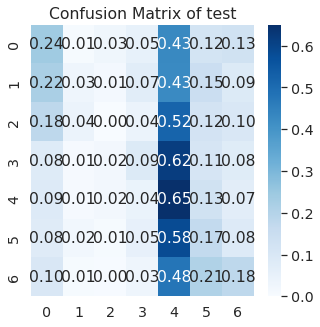

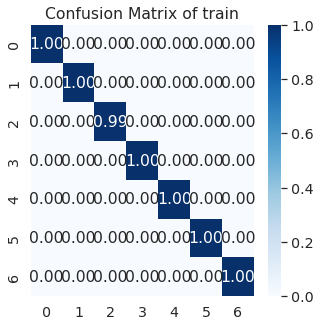

In [ ]:
y_pred = classifier.predict(X_test_pca)
y_train_pred = classifier.predict(X_train_pca)

cm_plot(y_test, y_pred, 'test')
cm_plot(y_train, y_train_pred, 'train')

In [ ]:
balanced_accuracy_score(y_test, y_pred)

0.19344254504455152

In [ ]:
X_train_optuna_mlp, X_val_mlp, y_train_mlp, y_val_mlp = train_test_split(X_train_pca,
                                                                         y_train, 
                                                                         test_size=0.3, 
                                                                         random_state=123, 
                                                                         shuffle=True)

def objective(trial):

    global X_train_optuna_mlp, y_train_mlp, X_val_mlp, y_val_mlp

    params = {
        'learning_rate_init': trial.suggest_float('learning_rate_init ', 1e-6, 1e-2),
        'first_layer_neurons': trial.suggest_int('first_layer_neurons', 1, 201, step=10),
        'second_layer_neurons': trial.suggest_int('second_layer_neurons', 1, 201, step=10),
        'activation': trial.suggest_categorical('activation', ['identity', 'logistic', 'tanh', 'relu']),
        'alpha': trial.suggest_float('alpha ', 1e-6, 1e-3),
        'max_iter': trial.suggest_int('max_iter', 10, 1e4, step=10),
    }

    model = MLPClassifier(
        hidden_layer_sizes=(params['first_layer_neurons'], params['second_layer_neurons']),
        learning_rate_init=params['learning_rate_init'],
        activation=params['activation'],
        random_state=123,
        max_iter=params['max_iter'],
        alpha=params['alpha'],
    )

    model.fit(X_train_optuna_mlp, y_train_mlp)

    return balanced_accuracy_score(model.predict(X_val_mlp), y_val_mlp)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2023-02-25 23:43:15,466] A new study created in memory with name: no-name-2faeb87c-a4f4-49f6-8092-9d1d91e48175
[I 2023-02-25 23:43:41,422] Trial 0 finished with value: 0.19276652811069744 and parameters: {'learning_rate_init ': 0.0035055293073142394, 'first_layer_neurons': 21, 'second_layer_neurons': 141, 'activation': 'relu', 'alpha ': 0.0008411984063619338, 'max_iter': 2430}. Best is trial 0 with value: 0.19276652811069744.
[I 2023-02-25 23:44:07,813] Trial 1 finished with value: 0.1875648604342175 and parameters: {'learning_rate_init ': 0.004901649979553203, 'first_layer_neurons': 61, 'second_layer_neurons': 11, 'activation': 'relu', 'alpha ': 7.889160062025603e-05, 'max_iter': 5640}. Best is trial 0 with value: 0.19276652811069744.
[I 2023-02-25 23:45:06,751] Trial 2 finished with value: 0.19158128231451071 and parameters: {'learning_rate_init ': 0.009531978062837426, 'first_layer_neurons': 121, 'second_layer_neurons': 31, 'activation': 'tanh', 'alpha ': 0.00032531518510993873, 

0.35555555555555557


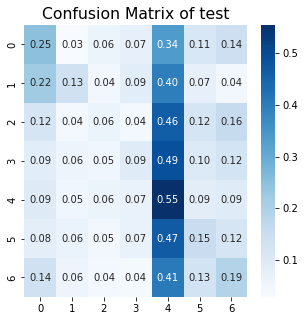

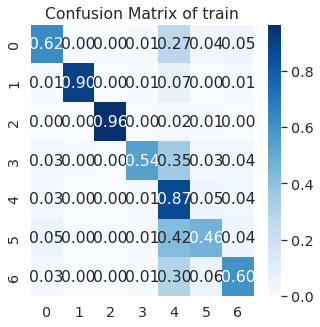

In [ ]:
parameters = {'hidden_layer_sizes': (111, 31),
              'learning_rate_init': 0.002364879625118581, 
              'activation': 'identity', 
              'alpha': 0.0004970917734427107,
              'max_iter': 2130} 
              
classifier = MLPClassifier(**parameters, random_state=3) 

classifier.fit(X_train_pca, y_train)
print(classifier.score(X_test_pca, y_test))

y_pred = classifier.predict(X_test_pca)
y_train_pred = classifier.predict(X_train_pca)

cm_plot(y_test, y_pred, 'test')
cm_plot(y_train, y_train_pred, 'train')

In [ ]:
statistic(y_pred, y_test, y_train_pred, y_train)

,train,test
balanced_accuracy_score,0.708683,0.204432
accuracy_score,0.720271,0.355556
f1 weighted,0.710443,0.358583
f1 micro,0.720271,0.355556
f1 macro,0.734789,0.199567


### Без PCA

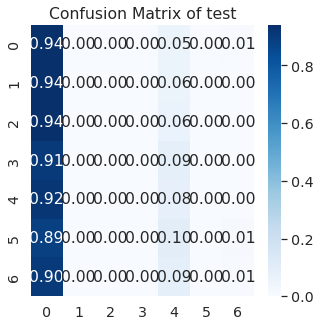

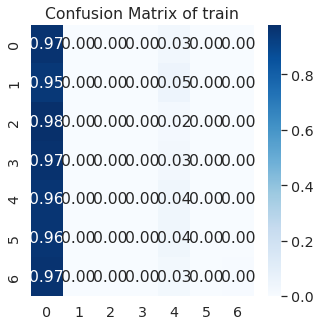

In [ ]:
classifier = MLPClassifier()

classifier.fit(X_train, y_train)
classifier.score(X_test, y_test)

y_pred = classifier.predict(X_test)
y_train_pred = classifier.predict(X_train)

cm_plot(y_test, y_pred, 'test')
cm_plot(y_train, y_train_pred, 'train')

## Опыты с SVM
### С PCA components = 3000

In [ ]:
X_train_pca_3000 = X_train.copy()
X_test_pca_3000 = X_test.copy()

scaler = StandardScaler()
scaler.fit(X_train_pca_3000)

X_train_pca_3000 = scaler.transform(X_train_pca_3000)
X_test_pca_3000 = scaler.transform(X_test_pca_3000)

n = 3000
pca = PCA(n_components=n, random_state=123)
pca.fit(X_train_pca_3000)

X_train_pca_3000 = pca.transform(X_train_pca_3000)
X_test_pca_3000 = pca.transform(X_test_pca_3000)

In [ ]:
classifier = sklearn.svm.SVC() #3000 7m

classifier.fit(X_train_pca_3000, y_train)

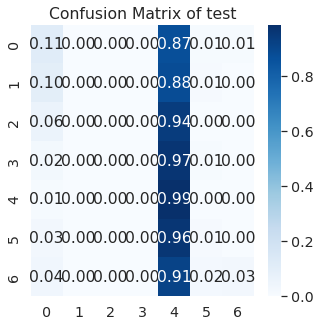

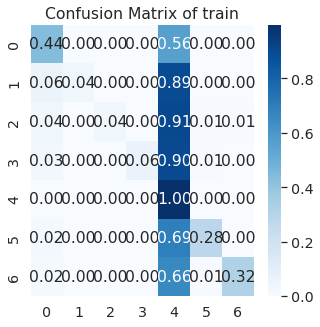

,train,test
balanced_accuracy_score,0.311328,0.162917
accuracy_score,0.608881,0.494636
f1 weighted,0.542242,0.351686
f1 micro,0.608881,0.494636
f1 macro,0.352935,0.13144


In [ ]:
y_pred = classifier.predict(X_test_pca_3000)
y_train_pred = classifier.predict(X_train_pca_3000)

cm_plot(y_test, y_pred, 'test')
cm_plot(y_train, y_train_pred, 'train')

statistic(y_pred, y_test, y_train_pred, y_train)

### С PCA components = 2000

In [ ]:
classifier = sklearn.svm.SVC() #2000 4m

classifier.fit(X_train_pca, y_train)

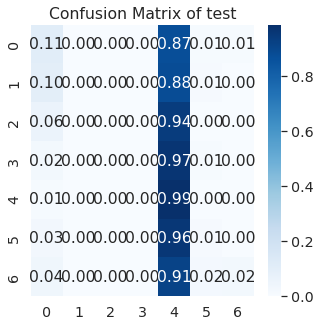

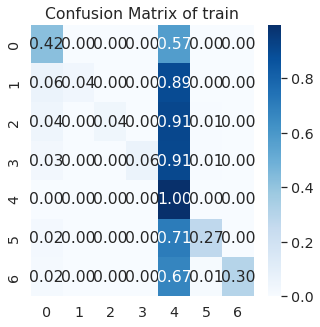

,train,test
balanced_accuracy_score,0.304208,0.162349
accuracy_score,0.602471,0.494253
f1 weighted,0.533408,0.35103
f1 micro,0.602471,0.494253
f1 macro,0.343785,0.130443


In [ ]:
y_pred = classifier.predict(X_test_pca)
y_train_pred = classifier.predict(X_train_pca)

cm_plot(y_test, y_pred, 'test')
cm_plot(y_train, y_train_pred, 'train')

statistic(y_pred, y_test, y_train_pred, y_train)

### Подбор параметров

In [ ]:
def objective(trial):
    global X_train_pca, y_train

    c = trial.suggest_float("svc_c", 1e-10, 1e2, log=True)

    clf = sklearn.svm.SVC(C=c, random_state=3)

    score = sklearn.model_selection.cross_val_score(clf, X_train_pca, y_train, cv=3, scoring='balanced_accuracy')
    accuracy = score.mean()
    return accuracy


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=25)
print(study.best_trial)

[I 2023-02-26 15:40:43,560] A new study created in memory with name: no-name-b1f48a3b-6353-471a-bdaf-e52f6586b111
[I 2023-02-26 15:49:25,303] Trial 0 finished with value: 0.14285714285714285 and parameters: {'svc_c': 0.12746681244209324}. Best is trial 0 with value: 0.14285714285714285.
[I 2023-02-26 15:54:53,077] Trial 1 finished with value: 0.14285714285714285 and parameters: {'svc_c': 8.050616772773905e-07}. Best is trial 0 with value: 0.14285714285714285.
[I 2023-02-26 16:04:58,914] Trial 2 finished with value: 0.19542461970945224 and parameters: {'svc_c': 70.38174501268244}. Best is trial 2 with value: 0.19542461970945224.
[I 2023-02-26 16:14:59,504] Trial 3 finished with value: 0.19542461970945224 and parameters: {'svc_c': 24.063089583875538}. Best is trial 2 with value: 0.19542461970945224.
[I 2023-02-26 16:24:56,942] Trial 4 finished with value: 0.19362927819225143 and parameters: {'svc_c': 5.322598776281117}. Best is trial 2 with value: 0.19542461970945224.
[I 2023-02-26 16:30

Тут проходил ручной подбор параметров, но часть кода скрыта в целях сохранения конфиденциальности.

# Нейронные сети. Мел-кепстральные коэф и мел-спектрограммы.

## Работа с мел-спектрограммами. Неизмененный набор данных

### Загрузка и подготовка данных

In [ ]:
X_val, y_val = make_working_set(X_valid, dict_tar)
X_train, y_train = make_working_set(X_train, dict_tar)
X_test, y_test = make_working_set(X_test, dict_tar)

In [ ]:
distr_y(y_train, 'train')
distr_y(y_val, 'val')

unique values of train: [0 1 2 3 4 5 6]
counts: [1109  271  268  683 4710 1743 1205]

unique values of val: [0 1 2 3 4 5 6]
counts: [153  22  40 111 469 163 150]



In [ ]:
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [ ]:
train = Dataset_audio(X_train, y_train)
val = Dataset_audio(X_val, y_val)
test = Dataset_audio(X_test, y_test)

In [ ]:
hyper_params = {
                #secret
                }

log_parameters(experiment, hyper_params)

In [ ]:
train_dl = DataLoader(train, batch_size=hyper_params['batch_size'], num_workers=0,
                      shuffle=True)
val_dl = DataLoader(val, batch_size=hyper_params['batch_size'], 
                    shuffle=False, num_workers=0)

### Архитектура

In [ ]:
class cnn_model(nn.Module):
    def __init__(self):
        super(cnn_model, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(3, 3), stride=(1, 1))
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=(1, 1))
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), stride=(1, 1))
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3), stride=(1, 1))
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3, 3), stride=(1, 1))
        self.conv6 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), stride=(1, 1))
        
        #secret

        self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.conv1(x.float())
        x = self.bn1(x)
        x = F.relu(x)
        x = self.mp1(x)

        #secret)
        
        return self.softmax(self.fc4(x))

In [ ]:
model = cnn_model()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = model.to(device)
experiment.set_model_graph(model, True)

cuda


In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=hyper_params['lr'])

lr_scheduler = StepLR(optimizer, step_size=10, 
                      gamma=hyper_params['lr_decay'], verbose=True)

Adjusting learning rate of group 0 to 1.0000e-07.


### Обучение

In [ ]:
def train(model, criterion, optimizer, train_dl, val_dl, epochs, lr_scheduler: StepLR=None):
    
    train_losses = []
    val_losses = []
    
    best_model_params = deepcopy(model.state_dict())
    best_accuracy = 0.0
    
    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}\n',
              f'{"--------------------"}')
        train_loss = 0
        val_loss = 0
        model.train()

        corrects, total_count = 0, 0 
        
        for (x, y) in train_dl:
            if torch.cuda.is_available():
                x, y = x.cuda(), y.cuda() 
            y = y.squeeze()
            
            optimizer.zero_grad()
            output = model(x.float()) 
            
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()*x.size(0)
            
        train_loss = train_loss/len(train_dl.dataset)
        train_losses.append(train_loss)
        lr_scheduler.step() 
        experiment.log_metric('loss_train', train_loss)

        model.eval() 
        
        for x, y in val_dl:
            if torch.cuda.is_available():
                x, y = x.cuda(), y.cuda() 
            y = y.squeeze()

            output = model(x.float())
        
            loss = criterion(output, y)
            val_loss += loss.item()*x.size(0)
            
            corrects += (output.argmax(1) == y).sum().item()
        
        val_loss = val_loss/len(val_dl.dataset)
        accuracy = corrects/len(val_dl.dataset)
        experiment.log_metric('loss_val', val_loss)

        val_losses.append(val_loss)
        print(f'Train Loss: {train_loss:.4f} \t Val Loss: {val_loss:.4f} \t Val Accuracy: {accuracy:.4f}\n')
        
        if (accuracy > best_accuracy):
            best_accuracy = accuracy
            best_model_params = deepcopy(model.state_dict())
            
    print('Finished Training and the best accuracy is: {:.4f}'.format(best_accuracy))
    return train_losses, val_losses, best_model_params, best_accuracy

In [ ]:
train_losses, val_losses, best_model_params, best_accuracy = train(
                                         model, 
                                         criterion, 
                                         optimizer, 
                                         train_dl, 
                                         val_dl, 
                                         hyper_params['epochs'], 
                                         lr_scheduler)

Epoch 1/20
 --------------------


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Adjusting learning rate of group 0 to 1.0000e-07.
Train Loss: 1.9407 	 Val Loss: 1.9400 	 Val Accuracy: 0.4233

Epoch 2/20
 --------------------
Adjusting learning rate of group 0 to 1.0000e-07.
Train Loss: 1.9349 	 Val Loss: 1.9346 	 Val Accuracy: 0.4233

Epoch 3/20
 --------------------
Adjusting learning rate of group 0 to 1.0000e-07.
Train Loss: 1.9261 	 Val Loss: 1.9291 	 Val Accuracy: 0.4233

Epoch 4/20
 --------------------
Adjusting learning rate of group 0 to 1.0000e-07.
Train Loss: 1.9115 	 Val Loss: 1.9184 	 Val Accuracy: 0.4233

Epoch 5/20
 --------------------
Adjusting learning rate of group 0 to 1.0000e-07.
Train Loss: 1.8897 	 Val Loss: 1.8957 	 Val Accuracy: 0.4233

Epoch 6/20
 --------------------
Adjusting learning rate of group 0 to 1.0000e-07.
Train Loss: 1.8585 	 Val Loss: 1.8696 	 Val Accuracy: 0.4233

Epoch 7/20
 --------------------
Adjusting learning rate of group 0 to 1.0000e-07.
Train Loss: 1.8137 	 Val Loss: 1.8253 	 Val Accuracy: 0.4233

Epoch 8/20
 ------

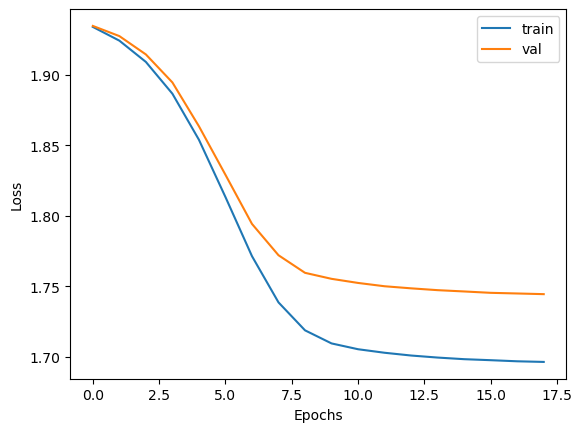

In [ ]:
plt.plot(np.convolve(train_losses, np.ones(3)/3, mode='valid'), label='train')
plt.plot(np.convolve(val_losses, np.ones(3)/3, mode='valid'), label='val')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
distr_y(y_test, 'test')

unique values of test: [0 1 2 3 4 5 6]
counts: [ 345   68   50  208 1256  402  281]



In [ ]:
model.load_state_dict(best_model_params)

test_dl = DataLoader(test, batch_size=hyper_params['batch_size'], 
                     shuffle=False, num_workers=0)

In [ ]:
y_pred = []
for x, y in test_dl:
    x = x.to(device)
    output = model(x) 
    y_pred.extend(torch.argmax(output, dim=1).cpu().numpy())

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
y_pred_val = []
for x, y in val_dl:
    x = x.to(device)
    output = model(x) 
    y_pred_val.extend(torch.argmax(output, dim=1).cpu().numpy())

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
accuracy_score(y_test, y_pred)

0.4812260536398467

## Работа с мел-спектрограммами. Данные длиной более 0.5

In [ ]:
path_dev = '/kaggle/input/meld-mel-spect/dev_05.npy'
path_train = '/kaggle/input/meld-mel-spect/train_05.npy'
path_test = '/kaggle/input/meld-mel-spect/mel_spect/test.npy'

hyper_params = {
                #secret
                }

Distribution of sets:


---


unique values of train: [0 1 2 3 4 5 6]

counts: [1075  268  265  675 4568 1678 1162]

---



unique values of val: [0 1 2 3 4 5 6]

counts: [148  22  37 107 455 160 144]

---



unique values of test: [0 1 2 3 4 5 6]

counts: [ 345   68   50  208 1256  402  281]

---



In [ ]:
model = cnn_model()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = model.to(device)
experiment.set_model_graph(model, True)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=hyper_params['lr'])

lr_scheduler = StepLR(optimizer, step_size=10, 
                      gamma=hyper_params['lr_decay'], verbose=True)

train_losses, val_losses, best_model_params, best_accuracy = train(
                                         model, 
                                         criterion, 
                                         optimizer, 
                                         train_dl, 
                                         val_dl, 
                                         hyper_params['epochs'], 
                                         lr_scheduler)

cuda
Adjusting learning rate of group 0 to 1.0000e-07.
Epoch 1/20
 --------------------


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Adjusting learning rate of group 0 to 1.0000e-07.
Train Loss: 1.9473 	 Val Loss: 1.9459 	 Val Accuracy: 0.1435

Epoch 2/20
 --------------------
Adjusting learning rate of group 0 to 1.0000e-07.
Train Loss: 1.9434 	 Val Loss: 1.9428 	 Val Accuracy: 0.1547

Epoch 3/20
 --------------------
Adjusting learning rate of group 0 to 1.0000e-07.
Train Loss: 1.9375 	 Val Loss: 1.9378 	 Val Accuracy: 0.2302

Epoch 4/20
 --------------------
Adjusting learning rate of group 0 to 1.0000e-07.
Train Loss: 1.9283 	 Val Loss: 1.9295 	 Val Accuracy: 0.4240

Epoch 5/20
 --------------------
Adjusting learning rate of group 0 to 1.0000e-07.
Train Loss: 1.9143 	 Val Loss: 1.9204 	 Val Accuracy: 0.4240

Epoch 6/20
 --------------------
Adjusting learning rate of group 0 to 1.0000e-07.
Train Loss: 1.8945 	 Val Loss: 1.9048 	 Val Accuracy: 0.4240

Epoch 7/20
 --------------------
Adjusting learning rate of group 0 to 1.0000e-07.
Train Loss: 1.8670 	 Val Loss: 1.8842 	 Val Accuracy: 0.4240

Epoch 8/20
 ------

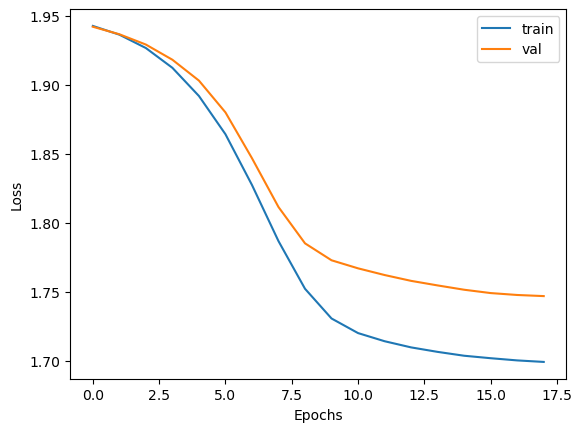

In [ ]:
plt.plot(np.convolve(train_losses, np.ones(3)/3, mode='valid'), label='train')
plt.plot(np.convolve(val_losses, np.ones(3)/3, mode='valid'), label='val')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
model.load_state_dict(best_model_params)

y_pred = []
for x, y in test_dl:
    x = x.to(device)
    output = model(x) 
    y_pred.extend(torch.argmax(output, dim=1).cpu().numpy())
    
with experiment.test():
    experiment.log_confusion_matrix(y_true=y_test, y_predicted=y_pred)
    
experiment.end()

y_pred_val = []
for x, y in val_dl:
    x = x.to(device)
    output = model(x) 
    y_pred_val.extend(torch.argmax(output, dim=1).cpu().numpy())
    
y_pred_train = []
for x, y in train_dl:
    x = x.to(device)
    output = model(x) 
    y_pred_train.extend(torch.argmax(output, dim=1).cpu().numpy())

In [ ]:
accuracy_score(y_test, y_pred)

0.4812260536398467

## MFCC. Измененные данные

In [ ]:
path_dev = '/kaggle/input/meld-mel-spect/dev_05mfcc.npy'
path_train = '/kaggle/input/meld-mel-spect/train_05mfcc.npy'
path_test = '/kaggle/input/meld-mel-spect/test_mfcc.npy'

hyper_params = {
    #secret
}


Distribution of sets:

unique values of train: [0 1 2 3 4 5 6]

counts: [1075  268  265  675 4568 1678 1162]

---



unique values of val: [0 1 2 3 4 5 6]

counts: [148  22  37 107 455 160 144]

---



unique values of test: [0 1 2 3 4 5 6]

counts: [ 345   68   50  208 1256  402  281]

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=(1, 1))
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=(1, 3))
        
        #secret

    def forward(self, x):
        x = self.conv1(x.float())
        x = self.bn1(x)
        x = F.relu(x)
        x = self.mp(x)
        x = self.dropout1(x)

        #secret :)

        return self.softmax(x)

In [ ]:
model = CNN()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = model.to(device)
experiment.set_model_graph(model, True)

cuda


In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=hyper_params['lr'])

lr_scheduler = StepLR(optimizer, step_size=10, 
                      gamma=hyper_params['lr_decay'], verbose=True)

Adjusting learning rate of group 0 to 1.0000e-07.


In [ ]:
def train(model, criterion, optimizer, train_dl, val_dl, epochs, lr_scheduler: StepLR=None):
    
    train_losses = []
    val_losses = []
    
    best_model_params = deepcopy(model.state_dict())
    best_accuracy, best_val = 0.0, 100.0
    
    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}\n',
              f'{"--------------------"}')
        train_loss = 0
        val_loss = 0
        model.train()

        corrects, total_count = 0, 0 
        
        for (x, y) in train_dl:
            if torch.cuda.is_available():
                x, y = x.cuda(), y.cuda() 
            y = y.squeeze()
            
            optimizer.zero_grad()
            output = model(x.float()) 
            
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()*x.size(0)
            
        train_loss = train_loss/len(train_dl.dataset)
        train_losses.append(train_loss)
        lr_scheduler.step() 
        experiment.log_metric('loss_train', train_loss)

        model.eval() 
        
        for x, y in val_dl:
            if torch.cuda.is_available():
                x, y = x.cuda(), y.cuda() 
            y = y.squeeze()

            output = model(x.float())
        
            loss = criterion(output, y)
            val_loss += loss.item()*x.size(0)
            
            corrects += (output.argmax(1) == y).sum().item()
        
        val_loss = val_loss/len(val_dl.dataset)
        accuracy = corrects/len(val_dl.dataset)
        experiment.log_metric('loss_val', val_loss)

        val_losses.append(val_loss)
        print(f'Train Loss: {train_loss:.4f} \t Val Loss: {val_loss:.4f} \t Val Accuracy: {accuracy:.4f}\n')
        
        if (accuracy >= best_accuracy and val_loss <= best_val):
            best_accuracy = accuracy
            best_val = val_loss
            best_model_params = deepcopy(model.state_dict())
            
    print('Finished Training and the best accuracy is: {:.4f}'.format(best_accuracy))
    return train_losses, val_losses, best_model_params, best_accuracy

In [ ]:
train_losses, val_losses, best_model_params, best_accuracy = train(
                                         model, 
                                         criterion, 
                                         optimizer, 
                                         train_dl, 
                                         val_dl, 
                                         hyper_params['epochs'], 
                                         lr_scheduler)

Epoch 1/20
 --------------------


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Adjusting learning rate of group 0 to 1.0000e-07.
Train Loss: 1.9458 	 Val Loss: 1.9459 	 Val Accuracy: 0.1342

Epoch 2/20
 --------------------
Adjusting learning rate of group 0 to 1.0000e-07.
Train Loss: 1.9380 	 Val Loss: 1.9416 	 Val Accuracy: 0.1342

Epoch 3/20
 --------------------
Adjusting learning rate of group 0 to 1.0000e-07.
Train Loss: 1.9292 	 Val Loss: 1.9369 	 Val Accuracy: 0.1547

Epoch 4/20
 --------------------
Adjusting learning rate of group 0 to 1.0000e-07.
Train Loss: 1.9187 	 Val Loss: 1.9315 	 Val Accuracy: 0.3131

Epoch 5/20
 --------------------
Adjusting learning rate of group 0 to 1.0000e-07.
Train Loss: 1.9064 	 Val Loss: 1.9254 	 Val Accuracy: 0.4101

Epoch 6/20
 --------------------
Adjusting learning rate of group 0 to 1.0000e-07.
Train Loss: 1.8923 	 Val Loss: 1.9186 	 Val Accuracy: 0.4231

Epoch 7/20
 --------------------
Adjusting learning rate of group 0 to 1.0000e-07.
Train Loss: 1.8762 	 Val Loss: 1.9116 	 Val Accuracy: 0.4240

Epoch 8/20
 ------

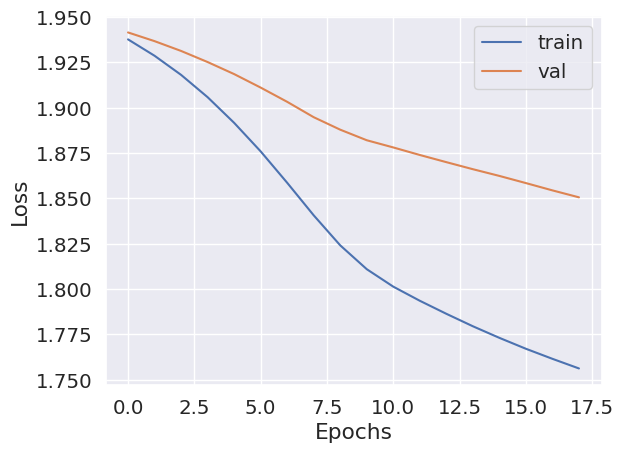

In [ ]:
plt.plot(np.convolve(train_losses, np.ones(3)/3, mode='valid'), label='train')
plt.plot(np.convolve(val_losses, np.ones(3)/3, mode='valid'), label='val')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
model.load_state_dict(best_model_params)

y_pred = []
for x, y in test_dl:
    x = x.to(device)
    output = model(x) 
    y_pred.extend(torch.argmax(output, dim=1).cpu().numpy())
    
with experiment.test():
    experiment.log_confusion_matrix(y_true=y_test, y_predicted=y_pred)
    
experiment.end()

y_pred_val = []
for x, y in val_dl:
    x = x.to(device)
    output = model(x) 
    y_pred_val.extend(torch.argmax(output, dim=1).cpu().numpy())
    
y_pred_train = []
for x, y in train_dl:
    x = x.to(device)
    output = model(x) 
    y_pred_train.extend(torch.argmax(output, dim=1).cpu().numpy())

In [ ]:
accuracy_score(y_test, y_pred)

0.4812260536398467

# Сохранение итоговой модели

In [ ]:
from pickle import dump as _save_

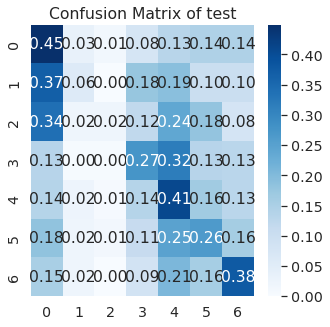

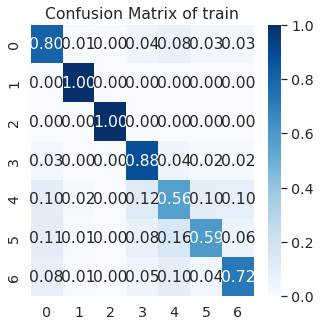

,train,test
balanced_accuracy_score,0.793905,0.264384
accuracy_score,0.660721,0.360536
f1 weighted,0.662948,0.376306
f1 micro,0.660721,0.360536
f1 macro,0.707244,0.243974


In [ ]:
classifier = sklearn.svm.SVC(C=xxx, random_state=3, probability=True)

classifier.fit(X_train_pca, y_train)

y_pred = classifier.predict(X_test_pca)
y_train_pred = classifier.predict(X_train_pca)

cm_plot(y_test, y_pred, 'test')
cm_plot(y_train, y_train_pred, 'train')

statistic(y_pred, y_test, y_train_pred, y_train)

In [ ]:
f = open('PCA.pickle', 'wb')
_save_(pca, f)
f.close()

In [ ]:
f = open('scaler.pickle', 'wb')
_save_(scaler, f)
f.close()

In [ ]:
f = open('/content/gdrive/MyDrive/Colab Notebooks/profect/SVC_model_audio_36score.pickle', 'wb')
_save_(classifier, f)
f.close()